# Install modules

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 24.6 MB/s eta 0:00:00


In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=87ed30190a2b78b91d5abfe3984eda419f5f3b7d16068b5366e2ec1015d35922
  Stored in directory: /root/.cache/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


In [ ]:
# Import modules
import tensorflow as tf
import tensorflow.keras as K

from tensorflow.keras.applications import VGG16

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense

import numpy as np
import librosa.display, os
import keras.utils as image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow_hub as hub
import datetime
import matplotlib.pyplot as plt

In [ ]:
# For XAI
import lime
from skimage.segmentation import mark_boundaries

from tensorflow import keras
import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.utils import load_img, img_to_array
import requests
from skimage.segmentation import slic
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import shap
import warnings

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
import lime.lime_image

In [ ]:
def generate_prediction_sample(exp, exp_class, weight = 0.1, show_positive = True, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=show_positive, 
                                         num_features=6, 
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    %matplotlib inline
    plt.imshow(mark_boundaries(image, mask))
    plt.plot()

# Load data

In [ ]:
!mkdir /content/Spectrogram

In [ ]:
!unzip "/content/drive/MyDrive/Spectrograms_training.zip" -d "/content/Spectrogram"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Spectrogram/real/recording8450.png_norm_mono.png  
  inflating: /content/Spectrogram/real/recording11067.png_norm_mono.png  
  inflating: /content/Spectrogram/real/recording6690.png_norm_mono.png  
  inflating: /content/Spectrogram/real/recording11512.png_norm_mono.png  
  inflating: /content/Spectrogram/real/recording7481.png_norm_mono.png  
  inflating: /content/Spectrogram/real/recording9871.png_norm_mono.png  
  inflating: /content/Spectrogram/real/recording10848.png_norm_mono.png  
  inflating: /content/Spectrogram/real/recording12330.png_norm_mono.png  
  inflating: /content/Spectrogram/real/recording9474.png_norm_mono.png  
  inflating: /content/Spectrogram/real/recording12415.png_norm_mono.png  
  inflating: /content/Spectrogram/real/recording9204.png_norm_mono.png  
  inflating: /content/Spectrogram/real/recording8878.png_norm_mono.png  
  inflating: /content/Spectrogram/real/recording11959.png_norm_mono.

In [ ]:
# Load data parameters
tf.random.set_seed(42)

batch_size = 32
img_height = img_width = 224
channels = 3
epochs = 20
input_shape = (224, 224, 3)

root = '/content/Spectrogram' #r'path_to_Spectrogram_folder' 

In [ ]:
train_ds = K.utils.image_dataset_from_directory(str(root), 
                                               validation_split = 0.2,
                                               subset = 'training',
                                               seed = 42,
                                               image_size = (img_height, img_width),
                                               batch_size = batch_size)

test_ds = K.utils.image_dataset_from_directory(str(root), 
                                               validation_split = 0.2,
                                               subset = 'validation',
                                               seed = 42,
                                               image_size = (img_height, img_width),
                                               batch_size = batch_size)

Found 10208 files belonging to 2 classes.
Using 8167 files for training.
Found 10208 files belonging to 2 classes.
Using 2041 files for validation.


In [ ]:
class_names = np.array(train_ds.class_names)
print(class_names)

['fake' 'real']


In [ ]:
# 32 (224*224*3) sized images in 1 batch
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [ ]:
total_train_samples = len(train_ds)
steps_per_epoch = tf.math.ceil(total_train_samples / batch_size)

In [ ]:
total_val_samples = len(test_ds)
validation_steps = tf.math.ceil(total_val_samples / batch_size)

# InceptionV3

**Preprocessing**

In [ ]:
# Download inception v3 model
feature_extractor2 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_layer2 = hub.KerasLayer(
    feature_extractor2,
    input_shape=(224, 224, 3),
    trainable=False)

feature_batch2 = feature_extractor_layer2(image_batch)
print(feature_batch2.shape)

(32, 2048)


In [ ]:
# Load pretrained model. Adding an output layer with 1 neuron
model_inception = tf.keras.Sequential([
    feature_extractor_layer2,
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_inception.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 24,951,585
Trainable params: 3,148,801
Non

In [ ]:
# Compile the model and define folder to store logs
model_inception.compile(optimizer=tf.keras.optimizers.Adam(), 
                     loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                     metrics=['acc'])

log_dir = "logs/fit/" + "inception-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq = 1)

**Training**

In [ ]:
# Takes a while to train. Set to 2 epochs. Increase if needed
history_inception = model_inception.fit(train_ds,
                    validation_data = test_ds,
                    epochs = 20,
                    callbacks = tensorboard_callback)

Epoch 1/20
256/256 [==============================] - 72s 239ms/step - loss: 2.3069 - acc: 0.6531 - val_loss: 0.5975 - val_acc: 0.6796
Epoch 2/20
256/256 [==============================] - 54s 202ms/step - loss: 0.5630 - acc: 0.6960 - val_loss: 0.4792 - val_acc: 0.7570
Epoch 3/20
256/256 [==============================] - 40s 154ms/step - loss: 0.5364 - acc: 0.7014 - val_loss: 0.4785 - val_acc: 0.7692
Epoch 4/20
256/256 [==============================] - 40s 150ms/step - loss: 0.5761 - acc: 0.6617 - val_loss: 0.4603 - val_acc: 0.7683
Epoch 5/20
256/256 [==============================] - 57s 217ms/step - loss: 0.5696 - acc: 0.6540 - val_loss: 0.4511 - val_acc: 0.7771
Epoch 6/20
256/256 [==============================] - 60s 231ms/step - loss: 0.5613 - acc: 0.6624 - val_loss: 0.4529 - val_acc: 0.7937
Epoch 7/20
256/256 [==============================] - 41s 157ms/step - loss: 0.5170 - acc: 0.7015 - val_loss: 0.4278 - val_acc: 0.7991
Epoch 8/20
256/256 [==============================] - 4

**Validation**

In [ ]:
# Check predictions
predicted_batch = model_inception.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print('Inception V3:',predicted_label_batch)

1/1 [==============================] - 2s 2s/step
Inception V3: ['fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake'
 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake'
 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake'
 'fake' 'fake']


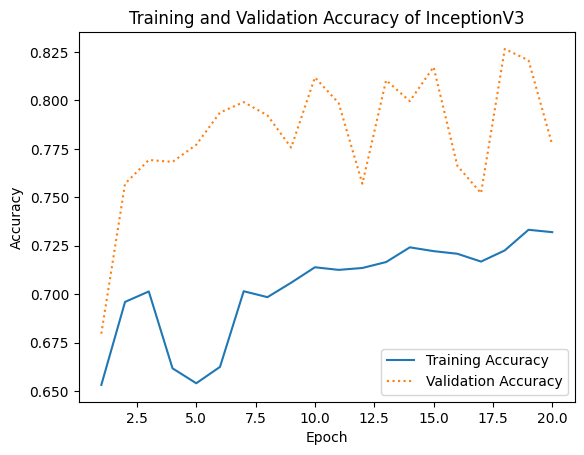

In [ ]:
# Plot accuracy curve
acc = history_inception.history['acc']
val_acc = history_inception.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of InceptionV3')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

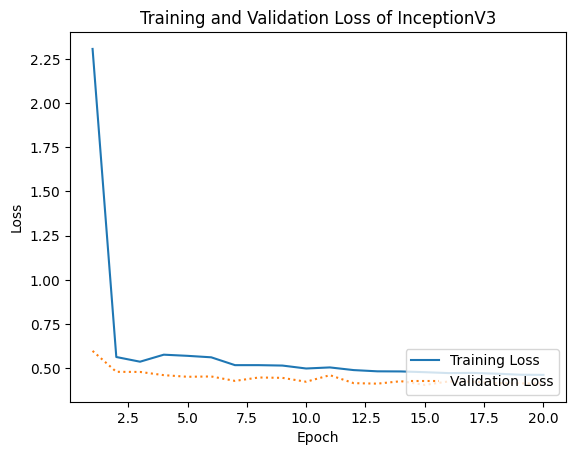

In [ ]:
# Plot loss curve
loss = history_inception.history['loss']
val_loss = history_inception.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, '-', label='Training Loss')
plt.plot(epochs, val_loss, ':', label='Validation Loss')
plt.title('Training and Validation Loss of InceptionV3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

**Save**

In [ ]:
model_inception.save_weights('./checkpoints/my_checkpoint')
model_inception.save('/content/drive/MyDrive/audio/my_inception')

## XAI for InceptionV3
1. Lime
2. SHAP
3. GradCAM

In [ ]:
model_inception = keras.models.load_model('/content/drive/MyDrive/audio/my_inception')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


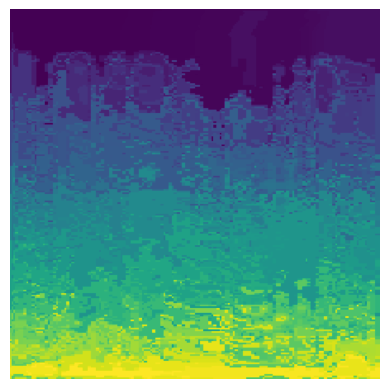

In [ ]:
import lime.lime_image

explainer = lime.lime_image.LimeImageExplainer()
exp = explainer.explain_instance(np.array(image_batch[0]),
                                model_inception.predict,
                                hide_color = 0,
                                num_samples = 1000)
plt.imshow(exp.segments)
plt.axis('off')
plt.show()

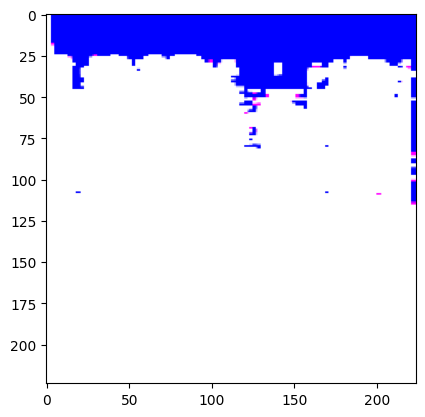

In [ ]:
# Features of spectrogram used to identify data as real -> 0
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = False)

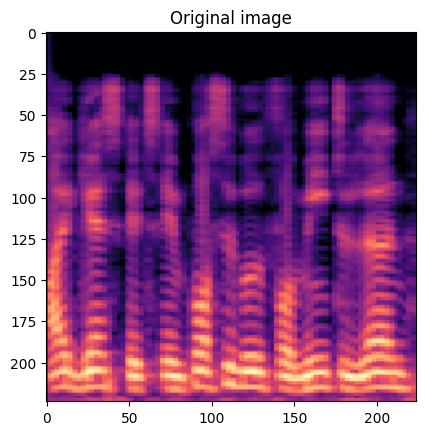

In [ ]:
file = r'/content/Spectrogram/fake/recording1002.png_norm_mono.png'
img = load_img(file, target_size = (224, 224))
img_orig = img_to_array(img)
plt.title('Original image')
plt.imshow(img)
plt.show()

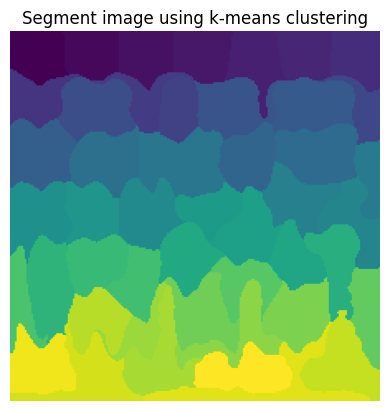

In [ ]:
segments_slic = slic(img, n_segments=50, compactness=30, sigma=3)
plt.imshow(segments_slic);
plt.title('Segment image using k-means clustering')
plt.axis('off')
plt.show()

In [ ]:
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out

def f(z):
    return model_inception.predict(preprocess_input(mask_image(z, segments_slic, img_orig, 255)))

In [ ]:
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000)

1/1 [==============================] - 2s 2s/step


  0%|          | 0/1 [00:00<?, ?it/s]

32/32 [==============================] - 3s 99ms/step


In [ ]:
# get the top predictions from the model
preds = model_inception.predict(preprocess_input(np.expand_dims(img_orig.copy(), axis=0)))
top_preds = np.argsort(-preds)
top_preds

1/1 [==============================] - 0s 37ms/step


array([[0]])

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
    
cm = LinearSegmentedColormap.from_list("shap", colors)
# Visualize the explanations
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

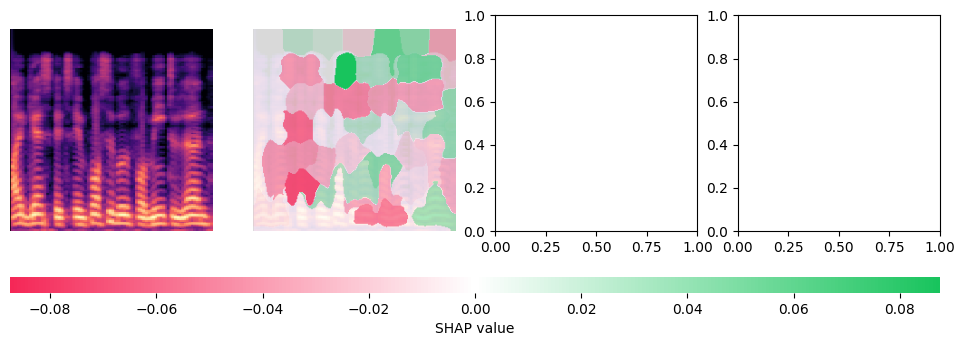

In [ ]:
# plot our explanations
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
inds = top_preds[0]
axes[0].imshow(img)
axes[0].axis('off')

max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
i = 0
m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
axes[i+1].imshow(img, alpha=0.15)
im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()

1/1 [==============================] - 0s 30ms/step


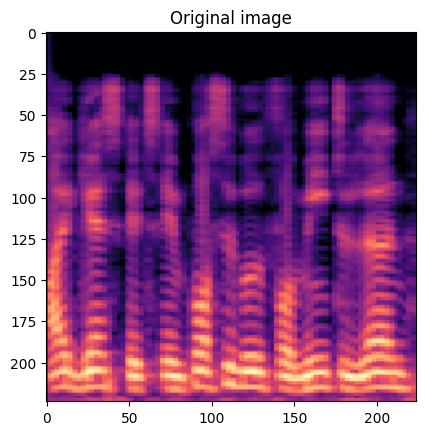

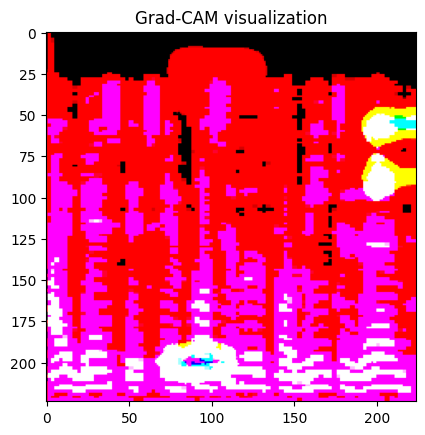

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load pre-trained VGG16 model
model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)

# Get the output tensor of the last convolutional layer
last_conv_layer = model.get_layer('block5_conv3')

# Create a new model that outputs the last convolutional layer activations and the final output predictions
grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

# Get the image you want to visualize
img = tf.keras.preprocessing.image.load_img(file, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img) # convert to numpy array
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.vgg16.preprocess_input(x)

# Get the predicted class index
preds = model_inception.predict(x)
class_idx = np.argmax(preds[0])

# Compute the gradient of the class output value with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(x)
    class_output = preds[:, class_idx]
grads = tape.gradient(class_output, last_conv_layer_output)

# Compute the channel-wise mean of the gradients
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Multiply each activation map with its corresponding gradient
last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

# Resize the heatmap to be the same size as the original image
heatmap = cv2.resize(np.float32(heatmap), (x.shape[2], x.shape[1]))

# Convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Convert heatmap to same datatype as input image
heatmap = heatmap.astype(np.float32)

# Overlay the heatmap on top of the original image
superimposed_img = cv2.addWeighted(x[0], 0.6, heatmap, 0.4, 0)

# Display the results
plt.imshow(img)
plt.title('Original image')
plt.show()

plt.imshow(superimposed_img)
plt.title('Grad-CAM visualization')
plt.show()

# MobileNet

In [ ]:
# Download mobilenet model
feature_extractor3 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor_layer3 = hub.KerasLayer(
    feature_extractor3,
    input_shape=(224, 224, 3),
    trainable=False)

feature_batch3 = feature_extractor_layer3(image_batch)
print(feature_batch3.shape)

(32, 1280)


**Construct**

In [ ]:
# Load pretrained model. Adding an output layer with 1 neurons

model_mobile = tf.keras.Sequential([
    feature_extractor_layer3,
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_mobile.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_3 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 4,620,353
Trainable params: 2,362,369
No

**Train**

In [ ]:
# Compile the model and define folder to store logs
model_mobile.compile(optimizer=tf.keras.optimizers.Adam(), 
                     loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                     metrics=['acc'])

log_dir = "logs/fit/" + "model-mobile-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq = 1)

In [ ]:
# Takes a while to train. Set to 2 epochs. Increase if needed
history_mobile = model_mobile.fit(train_ds,
                    validation_data = test_ds,
                    epochs = 20,
                    callbacks = tensorboard_callback)

Epoch 1/20
256/256 [==============================] - 44s 155ms/step - loss: 0.4517 - acc: 0.7914 - val_loss: 0.3460 - val_acc: 0.8398
Epoch 2/20
256/256 [==============================] - 32s 124ms/step - loss: 0.3232 - acc: 0.8605 - val_loss: 0.3902 - val_acc: 0.8045
Epoch 3/20
256/256 [==============================] - 32s 124ms/step - loss: 0.2959 - acc: 0.8749 - val_loss: 0.2857 - val_acc: 0.8731
Epoch 4/20
256/256 [==============================] - 33s 125ms/step - loss: 0.2844 - acc: 0.8766 - val_loss: 0.2646 - val_acc: 0.8893
Epoch 5/20
256/256 [==============================] - 34s 127ms/step - loss: 0.2671 - acc: 0.8847 - val_loss: 0.2566 - val_acc: 0.8849
Epoch 6/20
256/256 [==============================] - 37s 144ms/step - loss: 0.2524 - acc: 0.8915 - val_loss: 0.2700 - val_acc: 0.8922
Epoch 7/20
256/256 [==============================] - 37s 144ms/step - loss: 0.2466 - acc: 0.8956 - val_loss: 0.2449 - val_acc: 0.9035
Epoch 8/20
256/256 [==============================] - 3

In [ ]:
# Check predictions
predicted_batch = model_mobile.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print('Mobile net:',predicted_label_batch)

1/1 [==============================] - 1s 688ms/step
Mobile net: ['fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake'
 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake'
 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake'
 'fake' 'fake']


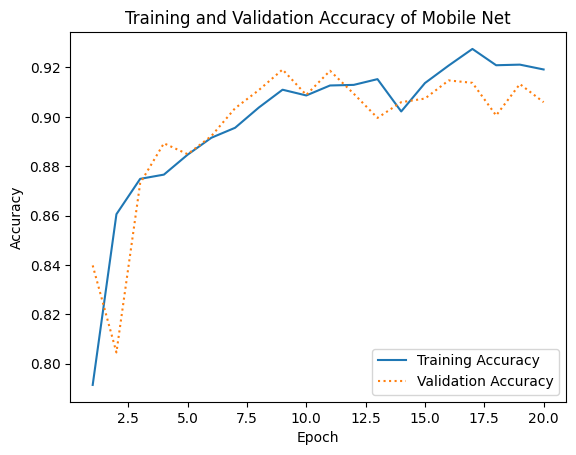

In [ ]:
# Plot accuracy curve
acc = history_mobile.history['acc']
val_acc = history_mobile.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of Mobile Net')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

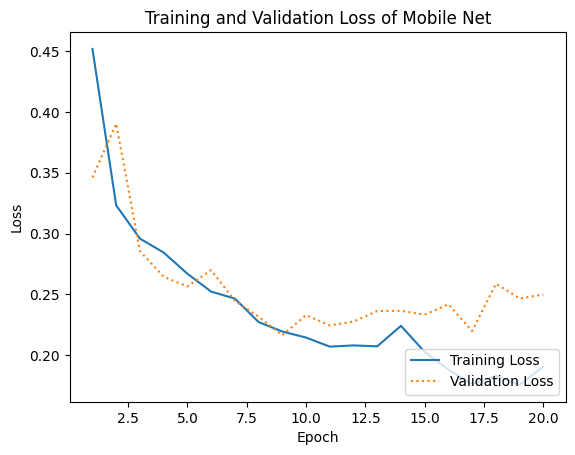

In [ ]:
# Plot loss curve
loss = history_mobile.history['loss']
val_loss = history_mobile.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, '-', label='Training Loss')
plt.plot(epochs, val_loss, ':', label='Validation Loss')
plt.title('Training and Validation Loss of Mobile Net')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_inception.save_weights('./checkpoints/my_checkpoint')
model_inception.save('/content/drive/MyDrive/audio/my_mobilenet')

## XAI for MobileNet
1. Lime
2. SHAP
3. GradCAM

In [ ]:
model_mobile = keras.models.load_model('/content/drive/MyDrive/audio/my_mobilenet')

In [1]:
import lime.lime_image

explainer = lime.lime_image.LimeImageExplainer()
exp = explainer.explain_instance(np.array(image_batch[0]),
                                model_mobile.predict,
                                hide_color = 0,
                                num_samples = 1000)
plt.imshow(exp.segments)
plt.axis('off')
plt.show()

NameError: name 'np' is not defined

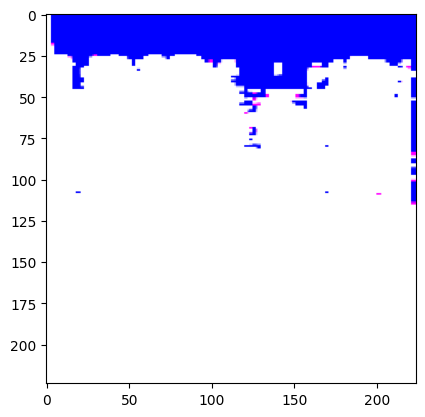

In [ ]:
# Features of spectrogram used to identify data as real -> 0
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = False)

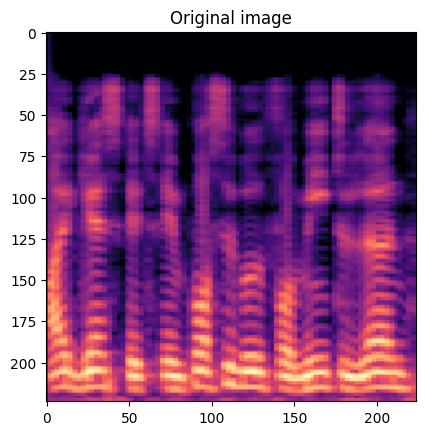

In [ ]:
file = r'/content/Spectrogram/fake/recording1002.png_norm_mono.png'
img = load_img(file, target_size = (224, 224))
img_orig = img_to_array(img)
plt.title('Original image')
plt.imshow(img)
plt.show()

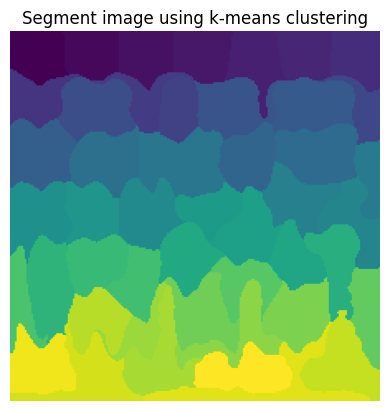

In [ ]:
segments_slic = slic(img, n_segments=50, compactness=30, sigma=3)
plt.imshow(segments_slic);
plt.title('Segment image using k-means clustering')
plt.axis('off')
plt.show()

In [ ]:
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out

def f(z):
    return model_mobile.predict(preprocess_input(mask_image(z, segments_slic, img_orig, 255)))

In [ ]:
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000)

1/1 [==============================] - 1s 751ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

32/32 [==============================] - 2s 77ms/step


In [ ]:
# get the top predictions from the model
preds = model_mobile.predict(preprocess_input(np.expand_dims(img_orig.copy(), axis=0)))
top_preds = np.argsort(-preds)
top_preds

1/1 [==============================] - 1s 752ms/step


array([[0]])

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
    
cm = LinearSegmentedColormap.from_list("shap", colors)
# Visualize the explanations
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

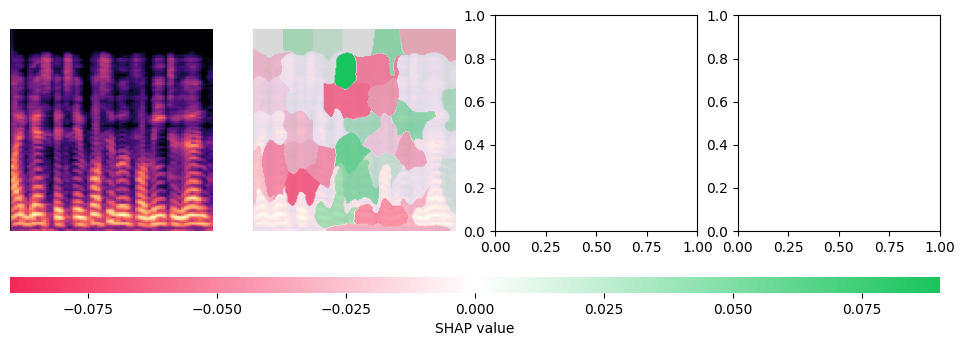

In [ ]:
# plot our explanations
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
inds = top_preds[0]
axes[0].imshow(img)
axes[0].axis('off')

max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(1):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].imshow(img, alpha=0.15)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()

1/1 [==============================] - 0s 48ms/step


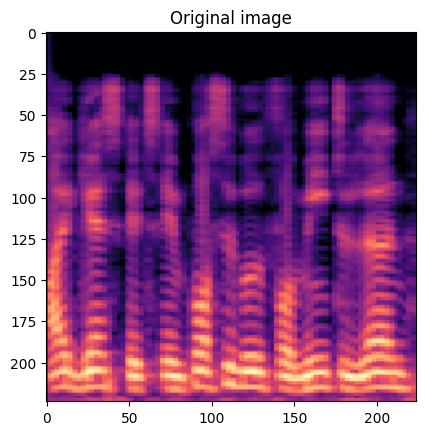

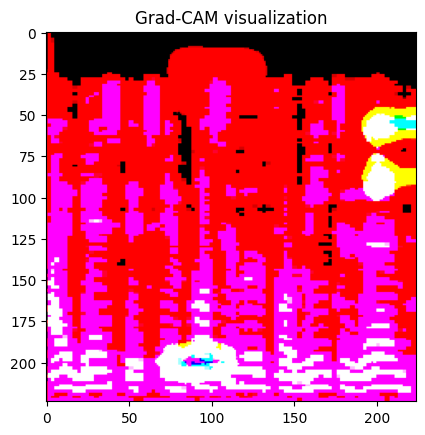

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load pre-trained VGG16 model
model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)

# Get the output tensor of the last convolutional layer
last_conv_layer = model.get_layer('block5_conv3')

# Create a new model that outputs the last convolutional layer activations and the final output predictions
grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

# Get the image you want to visualize
img = tf.keras.preprocessing.image.load_img(file, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img) # convert to numpy array
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.vgg16.preprocess_input(x)

# Get the predicted class index
preds = model_mobile.predict(x)
class_idx = np.argmax(preds[0])

# Compute the gradient of the class output value with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(x)
    class_output = preds[:, class_idx]
grads = tape.gradient(class_output, last_conv_layer_output)

# Compute the channel-wise mean of the gradients
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Multiply each activation map with its corresponding gradient
last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

# Resize the heatmap to be the same size as the original image
heatmap = cv2.resize(np.float32(heatmap), (x.shape[2], x.shape[1]))

# Convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Convert heatmap to same datatype as input image
heatmap = heatmap.astype(np.float32)

# Overlay the heatmap on top of the original image
superimposed_img = cv2.addWeighted(x[0], 0.6, heatmap, 0.4, 0)

# Display the results
plt.imshow(img)
plt.title('Original image')
plt.show()

plt.imshow(superimposed_img)
plt.title('Grad-CAM visualization')
plt.show()